In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np

In [4]:
import os
from os import listdir

In [5]:
DATA = "/kaggle/input"

In [ ]:
# explore the input data
# for dirname, _, filenames in os.walk(DATA):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [6]:
train_directory = os.path.join(DATA,'feedback-prize-2021','train')

In [7]:
test_directory = os.path.join(DATA,'feedback-prize-2021','test')

In [8]:
glove_directory = os.path.join(DATA,'glovedata')

In [9]:
root_directory = os.path.join(DATA,'feedback-prize-2021')

In [10]:
# explore the word2vec datasets
for dirname, _, filenames in os.walk(glove_directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glovedata/glove.6B.200d.txt
/kaggle/input/glovedata/glove.6B.50d.txt
/kaggle/input/glovedata/glove.6B.100d.txt


In [11]:
train_filename = "train.csv"

In [12]:
train_filepath = os.path.join(root_directory,train_filename)

In [13]:
essay_files = listdir(train_directory)

In [14]:
len(essay_files)

15594

In [ ]:
# to bring in the training set spreadsheet (.csv)

In [15]:
train_df = pd.read_csv(train_filepath)

In [16]:
train_df.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [17]:
print(len(train_df))

144293


In [18]:
def retrieveWordage(essay_id,directory):
  essay_filename = essay_id + ".txt"
  essay_filepath = os.path.join(directory,essay_filename)
  with open(essay_filepath) as file:
    file_contents = file.read()
  #try:
  #  essay_text = pd.read_table(essay_filepath,header=0,engine='python',error_bad_lines=False)
  #except:
  #  return None
  #essay_text.columns = ['narrative']
  #return essay_text
  essay_text = []
  essay_line = ""
  for c in file_contents:
    if c == '\n':
      if len(essay_line) > 1:
        essay_text.append(essay_line)
      essay_line = ""
    else:
      essay_line += c
  essay_text.append(essay_line)
  essay_pd = pd.DataFrame(essay_text)
  essay_pd.columns = ['narrative']
  return essay_pd

In [19]:
wordage_test = retrieveWordage("0027FC00C35B",train_directory)
print(wordage_test)

                                            narrative
0                                    Phones & Driving
1   Waking up from a wonderful dream, you look aro...
2   At this point you only have two options, are y...
3   In general, cell phones are a huge distraction...
4   In comparison, many other people may disagree ...
5   In my opinion, there shouldn't necessarily be ...
6   In conclusion, if causing harm and chaos is th...
7   Now back to the questions. Are you willing to ...
8                                          Work Cited
9   Ellis, Baldwin. "Pros of Driving & Cell Phone ...
10                                         Work Cited
11  Hilliard, Justin, et al. "Why You Really Shoul...
12                                         Work Cited
13  "Pros And Cons Of Using A Hands Free Mobile Ph...


In [20]:
def cleanText2(item):
  item2 = ""
  for ch in item:
      if ch == ' ' or (ch >= 'a' and ch <= 'z') or (ch >= 'A' and ch <= 'Z') or (ch >= '0' and ch <= '9'):
          if ch >= 'A' and ch <= 'Z':
              item2 += ch.lower()
          else:
              item2 += ch
  return item2

In [21]:
def retrieveEssay(essay_id,directory):
  essay_text = retrieveWordage(essay_id,directory)
  if essay_text is None:
        return None
  essay_count = len(essay_text)
  essay = ""
  for i in range(0,essay_count-1):
      essay += cleanText2(essay_text.iloc[i,0])
  return essay

In [22]:
def retrieveRawEssay(essay_id,directory):
  essay_text = retrieveWordage(essay_id,directory)
  if essay_text is None:
      return None
  essay_count = len(essay_text)
  essay = ""
  for i in range(0,essay_count-1):
      item = essay_text.iloc[i,0]
      essay += item
  return essay

In [23]:
essay_test = retrieveEssay("423A1CA112E2",train_directory)
print(essay_test)

phonesmodern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the united states ban phones from class rooms just because of itwhen people have phones they know about certain apps that they have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generationdriving is one of the way how to get around people always be on their phones while doing it which can cause serious problems thats why theres a thing thats called no texting while driving thats a really important thing to remember some people still do it beca

In [24]:
from tensorflow.data import Dataset

In [27]:
from tensorflow.data import TextLineDataset

In [28]:
def retrieveDataset(essay_id,directory):
  essay_array = []
  essay_text = retrieveWordage(essay_id,directory)
  if essay_text is None:
    return None
  essay_count = len(essay_text)
  #essay = ""
  for i in range(0,essay_count-1):
      essay_array.append(cleanText2(essay_text.iloc[i,0]))
  #essay = essay_text.iloc[0,0]
  dataset = Dataset.from_tensor_slices(essay_array)
  return dataset

In [29]:
test_dataset = retrieveDataset("423A1CA112E2",train_directory)
print(test_dataset)
for element in test_dataset:
    print(element)

<TensorSliceDataset shapes: (), types: tf.string>
tf.Tensor(b'phones', shape=(), dtype=string)
tf.Tensor(b'modern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the united states ban phones from class rooms just because of it', shape=(), dtype=string)
tf.Tensor(b'when people have phones they know about certain apps that they have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generation', shape=(), dtype=string)
tf.Tensor(b'driving is one of the way how to get around people always be on their phones whi

2022-03-04 05:13:32.848633: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [30]:
from tensorflow.keras.layers import TextVectorization

In [31]:
# Create the layer.
vectorize_layer = TextVectorization(
 max_tokens=5000,
 output_mode='int',
 output_sequence_length=500)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow import string as tf_string

In [33]:
def retrieveDiscourse(essay_id,discourse_id,discourse_start,discourse_end,directory):
  essay_text = retrieveRawEssay(essay_id,directory)
  essay_count = len(essay_text)
  i = 0
  discourse_text = ""
  for ch in essay_text:
     #print(ch) 
     if i >= discourse_start - 2 and i <= discourse_end + 1:
        discourse_text += ch
     i += 1
  return cleanText2(discourse_text)

In [34]:
test_discourse = retrieveDiscourse("423A1CA112E2",0,8,229,train_directory)
print(test_discourse)
print(len(test_discourse))

modern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving the
221


In [ ]:
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/pretrained_word_embeddings.ipynb#scrollTo=Q6j-LRMFc-AR

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [35]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import Model

In [36]:
essays_group = train_df.groupby(['id'])

In [37]:
class_dict = {}
samples = []
labels = []
class_index = 0
for essay_id, essay_pd in essays_group:  
  essay = retrieveEssay(essay_id,train_directory)
  if essay is None:
    break
  discourse_count = len(essay_pd)
  for i in range(0,discourse_count):
    item = essay_pd.iloc[i,]
    discourse_id = item['discourse_id']
    discourse_start = item['discourse_start']
    discourse_end = item['discourse_end']
    discourse_type = item['discourse_type']
    discourse_type = discourse_type.lower()
    if class_dict.get(discourse_type) == None:
      class_name_index = class_index
      class_dict[discourse_type] = class_name_index
      class_index += 1
    else:
      class_name_index = class_dict.get(discourse_type)
    discourse = retrieveDiscourse(essay_id,discourse_id,discourse_start,discourse_end,train_directory)
    samples.append(discourse)
    labels.append(class_name_index)

In [38]:
essay_array = []
samples_len = len(samples)
for i in range(0,samples_len):
  essay_text = samples[i]
  if essay_text != "":
      essay_array.append(essay_text)
vocab = Dataset.from_tensor_slices(essay_array)

In [52]:
# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for large
# datasets this means we're not keeping spare copies of the dataset.
vectorize_layer.adapt(vocab)

2022-03-04 05:33:07.163378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [53]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [60]:
print(len(word_index))

5000


In [61]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

In [62]:
path_to_glove_file = os.path.join(glove_directory,"glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [63]:
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4819 words (181 misses)


In [64]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

In [65]:
class_names = []
for key in class_dict:
  print(key)
  class_names.append(key)

position
evidence
claim
counterclaim
rebuttal
concluding statement
lead


In [67]:
print(class_dict)
print(class_names)

{'position': 0, 'evidence': 1, 'claim': 2, 'counterclaim': 3, 'rebuttal': 4, 'concluding statement': 5, 'lead': 6}
['position', 'evidence', 'claim', 'counterclaim', 'rebuttal', 'concluding statement', 'lead']


In [68]:
# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
test_samples = samples[-num_validation_samples:]

In [69]:
print(len(train_samples))
print(len(test_samples))

115435
28858


In [70]:
train_labels = labels[0:len(train_samples)]
test_labels = labels[len(train_samples):(len(train_samples)+len(test_samples))]

In [ ]:
# The class names should be the categories we are looking for.

In [76]:
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         500200    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         8204

In [71]:
x_train = vectorize_layer(np.array([[s] for s in train_samples])).numpy()
x_test = vectorize_layer(np.array([[s] for s in test_samples])).numpy()

In [73]:
y_train = np.array([[s] for s in train_labels])
y_test = np.array([[s] for s in test_labels])

In [77]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

In [78]:
#model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test))
model.fit(x_train, y_train, batch_size=128, epochs=20)
#model.fit(x_train,y_train)

Epoch 1/20
902/902 [==============================] - 250s 276ms/step - loss: 1.0931 - acc: 0.6524
Epoch 2/20
902/902 [==============================] - 249s 276ms/step - loss: 0.9596 - acc: 0.6910
Epoch 3/20
902/902 [==============================] - 249s 276ms/step - loss: 0.9035 - acc: 0.7062
Epoch 4/20
902/902 [==============================] - 247s 274ms/step - loss: 0.8642 - acc: 0.7170
Epoch 5/20
902/902 [==============================] - 248s 275ms/step - loss: 0.8279 - acc: 0.7302
Epoch 6/20
902/902 [==============================] - 248s 274ms/step - loss: 0.8044 - acc: 0.7361
Epoch 7/20
902/902 [==============================] - 248s 275ms/step - loss: 0.7842 - acc: 0.7423
Epoch 8/20
902/902 [==============================] - 247s 273ms/step - loss: 0.7692 - acc: 0.7474
Epoch 9/20
902/902 [==============================] - 247s 274ms/step - loss: 0.7567 - acc: 0.7508
Epoch 10/20
902/902 [==============================] - 248s 275ms/step - loss: 0.7462 - acc: 0.7544
Epoch 11/

In [ ]:
# Kaggle has a read-only file system so we might have to find another way to persist!
# path_to_model = os.path.join(DATA,'feedback-prize-2021','model')
# model.save(path_to_model)

In [79]:
y_result = model.predict(x_test)

In [80]:
print(len(y_result))

28858


In [81]:
yt0 = y_test[1]

In [82]:
y_rounded = np.round(y_result,1)

In [83]:
y0 = y_rounded[1]

In [84]:
print(y0)

[0. 1. 0. 0. 0. 0. 0.]


In [85]:
print(yt0)

[1]


In [86]:
print(len(y_rounded))
print(len(y_test))

28858
28858


In [87]:
for i in range(0,10):
    y_out = y_rounded[i]
    yt = y_test[i]
    print(y_out)
    print(yt)

[0.3 0.  0.1 0.  0.  0.  0.6]
[2]
[0. 1. 0. 0. 0. 0. 0.]
[1]
[0. 0. 0. 0. 0. 0. 1.]
[1]
[0.  0.1 0.5 0.2 0.2 0.  0. ]
[2]
[0.  0.6 0.1 0.  0.  0.  0.2]
[1]
[0.1 0.2 0.2 0.  0.  0.5 0. ]
[2]
[0.1 0.2 0.2 0.  0.  0.5 0. ]
[1]
[0.9 0.  0.  0.  0.  0.  0. ]
[0]
[0.1 0.  0.9 0.  0.  0.  0. ]
[2]
[0.1 0.3 0.4 0.1 0.1 0.  0. ]
[2]


In [88]:
# Create Statistics about Where Discourses are in Essays
# To do this we first create a pandas dataframe 'essay_statistics', per essay it lists
# essay_id,essay_length (in characters),discourse_count
class_dict = {}
samples = []
labels = []
class_index = 0
length_of_essay = 0
stats = []
for essay_id, essay_pd in essays_group: 
  stats_entry = []
  stats_entry.append(essay_id)
  essay = retrieveEssay(essay_id,train_directory)
  if essay is None:
    break
  length_of_essay = len(essay)
  stats_entry.append(length_of_essay)
  discourse_count = len(essay_pd)
  stats_entry.append(discourse_count)
  stats.append(stats_entry)
essay_statistics = pd.DataFrame(stats)

In [89]:
essay_statistics.head()

,0,1,2
0,0000D23A521A,985,8
1,00066EA9880D,3065,9
2,000E6DE9E817,1488,12
3,001552828BD0,2473,10
4,0016926B079C,1023,11


In [90]:
essay_statistics.columns = ['essay_id','essay_length','no_of_discourses']

In [91]:
essay_statistics.head()

,essay_id,essay_length,no_of_discourses
0,0000D23A521A,985,8
1,00066EA9880D,3065,9
2,000E6DE9E817,1488,12
3,001552828BD0,2473,10
4,0016926B079C,1023,11


In [92]:
import matplotlib.pyplot as plt

In [93]:
x = essay_statistics['essay_length']
y = essay_statistics['no_of_discourses']

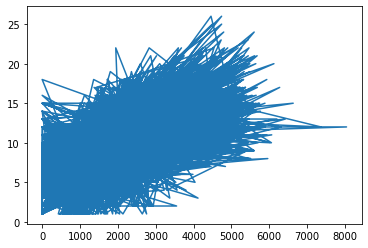

In [94]:
plt.plot(x,y)

In [ ]:
# https://realpython.com/numpy-scipy-pandas-correlation-python/#visualization-of-correlation

In [95]:
x.corr(y)

0.6120847388095774

In [96]:
y.corr(x)

0.6120847388095775

In [97]:
from scipy import stats as sci_stats

In [98]:
#https://realpython.com/numpy-scipy-pandas-correlation-python/#visualization-of-correlation
slope, intercept, r, p, stderr = sci_stats.linregress(x, y)

In [99]:
print(slope)
print(intercept)
print(r)
print(p)
print(stderr)

0.0018152953177363788
5.81630132079024
0.6120847388095774
0.0
1.878223150704505e-05


In [102]:
def returnExpectedDiscourses(essay_length):
    yyy = intercept + essay_length * slope
    return yyy

In [103]:
discourse_num_err = np.round(r,0)

In [104]:
print(discourse_num_err)

1.0


In [105]:
print(returnExpectedDiscourses(1000))

7.631596638526618


In [106]:
sample_x = []
sample_y = []
for i in range(0,8000,500):
    yy = returnExpectedDiscourses(i)
    sample_x.append(i)
    sample_y.append(yy)

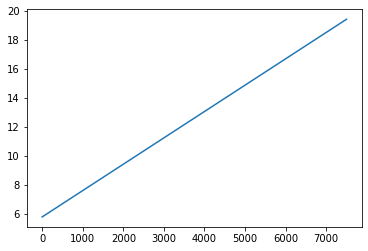

In [107]:
plt.plot(sample_x,sample_y)

In [108]:
essay_test = retrieveEssay("423A1CA112E2",train_directory)
print(essay_test)

phonesmodern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the united states ban phones from class rooms just because of itwhen people have phones they know about certain apps that they have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generationdriving is one of the way how to get around people always be on their phones while doing it which can cause serious problems thats why theres a thing thats called no texting while driving thats a really important thing to remember some people still do it beca

In [109]:
length_of_essay = len(essay_test)
expected_discourses = returnExpectedDiscourses(length_of_essay)
print(length_of_essay)
print(expected_discourses)

1487
8.515645458264235


In [110]:
expected_discourses = 13

In [111]:
# Start out with all discourses of even length
test_discourse = []
length_of_discourses = round(length_of_essay/expected_discourses,0)
print(length_of_discourses)

114.0


In [112]:
text_start = 0
discourse_element = []
test_discourse = []
for i in range(1,int(expected_discourses)):
    #print(i)
    text_end = text_start + length_of_discourses
    discourse_element.append(text_start)
    discourse_element.append(text_end)
    text_start = text_end + 1
    test_discourse.append(discourse_element)
    discourse_element = []
text_start = text_end + 1
text_end = length_of_essay
discourse_element.append(text_start)
discourse_element.append(text_end)
test_discourse.append(discourse_element)

In [117]:
# Given an expected length in characters
# the essay
# the offset
# returns a Prediction String as a numerical list
# Of word offsets into the essay
def returnPredictionStringFromCharacterOffsets(essay_text,start_offset,end_offset):
    ch_offset = 0
    record = 0
    word = 1
    prediction_string = ""
    word_count = 0
    for ch in essay_text:
        if ch == ' ':
            word += 1
            if record == 1:
                prediction_string += ' '
                prediction_string += str(word)
                word_count += 1
        if ch_offset >= start_offset and ch_offset <= end_offset:
            # ready to record
            record = 1
        elif ch_offset > end_offset:
            # turn off record
            record = 0
        ch_offset += 1
    return prediction_string

In [114]:
essay_test = retrieveEssay("423A1CA112E2",train_directory)
print(essay_test)

phonesmodern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the united states ban phones from class rooms just because of itwhen people have phones they know about certain apps that they have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generationdriving is one of the way how to get around people always be on their phones while doing it which can cause serious problems thats why theres a thing thats called no texting while driving thats a really important thing to remember some people still do it beca

In [118]:
prediction_string_test = returnPredictionStringFromCharacterOffsets(essay_test,25,50)
print(prediction_string_test)

 5 6 7 8 9


In [120]:
def returnPredictionStringsGivenExpectedNumberOfDiscourses(essay_text,number_of_discourses):
    prediction_strings = []
    text_start = 0
    text_end = 0
    essay_length = len(essay_text)
    discourse_length = round(essay_length / number_of_discourses)
    for i in range(0,number_of_discourses):
        text_end = text_start + discourse_length
        prediction_string = returnPredictionStringFromCharacterOffsets(essay_text,text_start,text_end)
        text_start = text_end + 1
        prediction_strings.append(prediction_string)
    return prediction_strings

In [128]:
prediction_strings = returnPredictionStringsGivenExpectedNumberOfDiscourses(essay_test,10)
print(prediction_strings)
print(len(prediction_strings))
for prediction_string in prediction_strings:
    #print(prediction_string)
    print(len(prediction_string.split(' ')))

[' 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30', ' 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59', ' 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85', ' 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114', ' 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138', ' 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167', ' 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194', ' 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223', ' 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251', ' 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268

In [ ]:
# Given a prediction string and a score, how do we know if the string can be improved.
# Do we remove a word and add another?
# The final test has to adjust the discourses appropriately to create the correct answer.
# Should we use the example prediction strings to somehow infer whether we are selecting the correct words?
# Haven't we already using the discourses to build the model?
#
# Certainly we could feed the proper discourses back into our model using the prediction string
# and see if we achieve the highest score that way
#
# Using the training set, can we create a set of adjustments that increase the score by adjusting the 
# predition string from the equal set where we have chopped the essay into the appropriate number of discourses
# to the prediction strings indicated by the high score.

In [235]:
def returnDiscoursesFromPredictionStrings(essay_id,directory,prediction_strings):
    discourses = []
    essay = retrieveEssay(essay_id,directory)
    if essay is None:
        return None
    discourse_count = len(prediction_strings)
    essay_words = essay.split(' ')
    #print(len(essay_words))
    for i in range(0,len(prediction_strings)):
        discourse = ""
        prediction_string = prediction_strings[i]
        prediction_numbers = prediction_string.split()
        for i in range(0,len(prediction_numbers)):
            prediction_number = int(prediction_numbers[i])
            #print(prediction_number)
            try:
                word = essay_words[prediction_number-1]
            except:
                word = ""
            #word = essay_words[int(prediction_number)]
            discourse += word
            discourse += " "
        discourses.append(discourse)
    return discourses

In [173]:
discourses_test = returnDiscoursesFromPredictionStrings("423A1CA112E2",train_directory,prediction_strings)
print(len(discourses_test))
for discourse in discourses_test:
    print(discourse)
    print(" ")

10
humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward 
 
and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone 
 
some certain areas in the united states ban phones from class rooms just because of itwhen people have phones they know about certain apps that they 
 
have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by 
 
posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generationdriving is 
 
one of the way how to get around people always be on their phones while doing it which can cause serious problems thats why theres a thing thats called 
 
no texting while driving thats a really important thing to remember some people still do

In [176]:
def returnPredictions(essay_id,directory,prediction_strings):
    discourses = returnDiscoursesFromPredictionStrings(essay_id,directory,prediction_strings)
    x_discourses = vectorize_layer(np.array([[s] for s in discourses])).numpy()
    predictions = model.predict(x_discourses)
    return predictions

In [177]:
y_result = returnPredictions("423A1CA112E2",train_directory,prediction_strings)

In [180]:
# We wish to have a good way to decide if a given 'fit' is good enough
# Given the results of model.predict of a given discourse using the prediction string above.
# This is a numerical value (statistic) between 0 and 1: Power
# Not arbitrary!
# Given the test result, compute the score
def returnScore(y_result):
    cumulative_score = 0
    number_of_items = 0
    for item in y_result:
        max_score = 0
        for score in item:
            if max_score < score:
                max_score = score
        cumulative_score += max_score
        number_of_items += 1
    #print(number_of_items)
    return cumulative_score / number_of_items

In [181]:
y_score = returnScore(y_result)
print(y_score)

0.4735818177461624


In [229]:
def returnTrainingStrings(essay_id,directory):
    predictions = []
    training_pd = train_df[train_df['id']==essay_id]
    predictionstrings = training_pd['predictionstring']
    for predictionstring in predictionstrings:
        prediction = ""
        for item in predictionstring:
            prediction += item
        predictions.append(prediction.lstrip())
    return predictions

In [230]:
training_strings = returnTrainingStrings("423A1CA112E2",train_directory)
print(training_strings)

['1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44', '45 46 47 48 49 50 51 52 53 54 55 56 57 58 59', '60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75', '76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138', '139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162', '163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210', '211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

In [231]:
print(len(prediction_strings))
print(len(training_strings))
print(prediction_strings[5])
print(training_strings[5])

10
10
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210


In [234]:
print(training_strings)

['1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44', '45 46 47 48 49 50 51 52 53 54 55 56 57 58 59', '60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75', '76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138', '139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162', '163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210', '211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 

In [236]:
y_training = returnPredictions("423A1CA112E2",train_directory,training_strings)

In [237]:
y_score_training = returnScore(y_training)
print(y_score_training)

0.5868387401103974


In [238]:
es = train_df[train_df['id']=="423A1CA112E2"]
print(es)

             id  discourse_id  discourse_start  discourse_end  \
0  423A1CA112E2  1.622628e+12              8.0          229.0   
1  423A1CA112E2  1.622628e+12            230.0          312.0   
2  423A1CA112E2  1.622628e+12            313.0          401.0   
3  423A1CA112E2  1.622628e+12            402.0          758.0   
4  423A1CA112E2  1.622628e+12            759.0          886.0   
5  423A1CA112E2  1.622628e+12            887.0         1150.0   
6  423A1CA112E2  1.622628e+12           1151.0         1533.0   
7  423A1CA112E2  1.622628e+12           1534.0         1602.0   
8  423A1CA112E2  1.622628e+12           1603.0         1890.0   
9  423A1CA112E2  1.622628e+12           1891.0         2027.0   

                                      discourse_text        discourse_type  \
0  Modern humans today are always on their phone....                  Lead   
1  They are some really bad consequences when stu...              Position   
2  Some certain areas in the United States ban ph.

In [255]:
def returnPredictionsFromResult(result,strings):
    i = 0
    for discourse_result in result:
        j = 0
        k = 0
        maxscore = 0
        for score in discourse_result:
            if score > maxscore:
                maxscore = score
                k = j
            j += 1
        try:
            class_name = class_names[k]
        except:
            class_name = "NA"
        try:
            stringlist = strings[i]
        except:
            stringlist = "NA"
        print("%i %s %s" % (i,class_name,stringlist))
        i += 1

In [250]:
returnPredictionsFromResult(y_result,prediction_strings)

0 claim  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
1 evidence  31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2 evidence  60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85
3 claim  86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
4 claim  115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
5 claim  139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
6 claim  168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
7 evidence  195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
8 evidence  224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
9 evidence  2

In [251]:
returnPredictionsFromResult(y_training,training_strings)

0 evidence 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
1 claim 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2 claim 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3 evidence 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
4 claim 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
5 evidence 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
6 evidence 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 

In [ ]:
# We are ready to run the test!

In [256]:
# explore the word2vec datasets
for dirname, _, filenames in os.walk(test_directory):
    for filename in filenames:
        essay_id = (filename.split('.'))[0]
        essay_test = retrieveEssay(essay_id,test_directory)
        essay_length = len(essay_test)
        number_of_discourses = int(round(returnExpectedDiscourses(essay_length))+1)
        X_strings = returnPredictionStringsGivenExpectedNumberOfDiscourses(essay_test,number_of_discourses)
        #X = returnDiscoursesFromPredictionStrings(essay_id,test_directory,X_strings)
        y = returnPredictions(essay_id,test_directory,X_strings)
        print(essay_id)
        returnPredictionsFromResult(y,prediction_strings)

0FB0700DAF44
0 evidence  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
1 claim  31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2 evidence  60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85
3 evidence  86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
4 evidence  115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
5 evidence  139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
6 evidence  168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
7 claim  195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
8 evidence  224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249